# Building a Dense Neural Network
In this notebook you will build your own dense neural network for 2-class prediction, implementing
1. Model architecture
2. Parameter initialization
3. Forward propagation
4. Loss function computation
5. Backward propagation
6. Gradient descent parameter update
7. Training algorithm
8. Prediction

At the end of this notebook you should have learned the following:
- An understanding of how a neural network is constructed
- How a neural network comes to a prediction
- How backward propagation and gradient descent trains a neural network
- How hidden layer dimension and learning rate influences the training and/or prediction outcome
- How the problem setting defines the performance of a neural network

## Import Python modules

In [4]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dnn_utils import sigmoid, visualize_decision_boundary

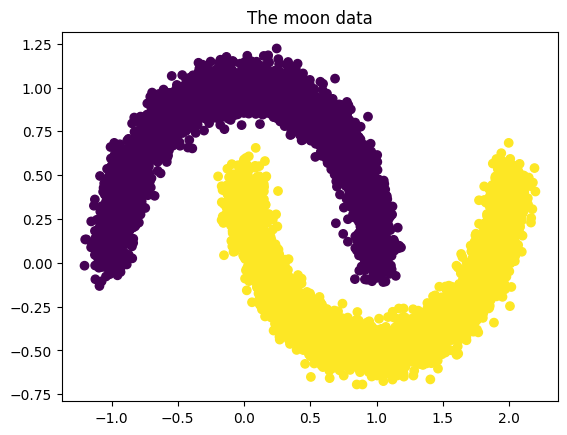

In [5]:
## Load the dataset
X, Y = datasets.make_moons(10000, noise=0.07, random_state=24 )
plt.scatter(X[:,0],X[:,1], c=Y)
plt.title('The moon data')
plt.show();

From the plot above, it can be seen clearly that the classes of this dataset cannot be separated by a linear decision boundary, so a logistic regression would do quite bad on it (try it out). 

Let us take a look at the data dimensions.

In [6]:
# Print the data dimensions
print(' input dimensions: {}'.format(X.shape))
print('output dimensions: {}'.format(Y.shape))

 input dimensions: (10000, 2)
output dimensions: (10000,)


## Prerequisite: Logistic regression
To have an appropriate benchmark model a logistic regression should be fit to the data. Note that a logistic regression possesses a linear decision boundary. For the data shown above this will be problematic. 

>__Exercise__: Fit a logistic regression model to the data and print out the test accuracy score. Use a 70/30 test split with a random seed of 42. Fit the model with the already imported `LogisticRegressionCV()`. Visualize the decision boundary by using the function `visualize_decision_boundary()` from the `dnn_utils.py`. Note that `visualize_decision_boundary()` expects a model's `predict()` function. This can be passed by using a `lambda` function: `lambda x: model.predict(x)`. 

test accuracy: 0.884667
Y shape: 1
X shape: (10000, 2)


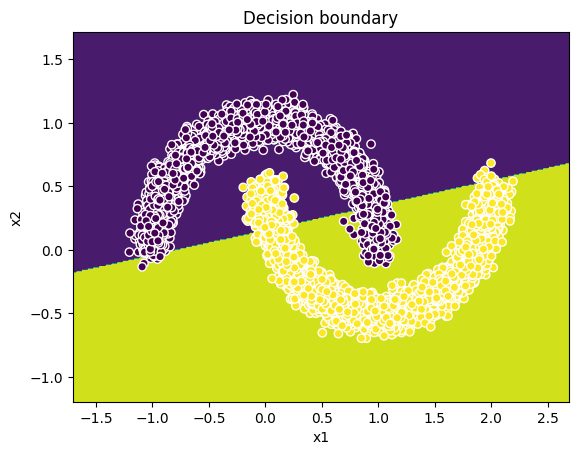

In [ ]:
#===========#
# YOUR CODE # ~ 4 lines
#===========#

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state=42)

log_reg_model = LogisticRegressionCV()
log_reg_model.fit(X_train, Y_train) 

# Plot the decision_boundary for the logistic regression model
visualize_decision_boundary(X_train, Y_train, lambda x: log_reg_model.predict(x))

# Print the accuracy of the logistic regression model
print('test accuracy: %f' % accuracy_score(Y_test, log_reg_model.predict(X_test)))
print(f"Y shape: {Y.shape)")
print(f"X shape: {X.shape}")

## 1. Model architecture
For each layer the number of parameters are defined by their input and ouput, respectively. The dense neural network has the following layers:

1. input layer
2. hidden layer
3. output layer

<img src="../images/artificial_network_architecture_dnn.png" alt="" width="400"/>


All layers have an input and output. The input layer's input are the number of features `n_input` in `X` and the output layer's output is the number of classes `n_output`. In the case of 2-class output we need only a single output, so `n_output=1`. The interesting part is the one that happens in the hidden layer. The input to this layer is defined by the output of the previous layer, the input layer. The size of the output of the input layer is `n_input` (remember: this is a throughput layer; it just passes through). The output dimension of the hidden layer is defined in the variable `n_hidden`. Together these variables define the size of the weight matrices and biases that need to be learned by the network.

>__Exercise__: Define a function that determines the dimensions of the layers.

In [18]:
def model_architecture(X,Y, n_hidden=10):
    """
    Defines the DNN model architecture
    
        Args:
        X: feature vector with shape (n_samples, n_input)
        Y: true target of shape (n_samples, 1)   
        n_hidden: size of the hidden layer (defined by user)    
        
        Returns:
        arch: model architecture with sizes of layers in a dict
    """
    
    # Define the layer sizes
    #===========#
    # YOUR CODE # ~ 3 lines
    #===========#
    
    #===========#
    # COMPLETE  # 
    #===========#    
    arch = {'n_input': X.shape[1], 'n_hidden': n_hidden, 'n_output': len(Y.shape)}

    return arch

In [19]:
model_arch = model_architecture(X_train, Y_train, n_hidden=8)
print('Neural Network Architecture: ')
print('----------------------------')
print('       Input dimension: %i' % model_arch['n_input'])
print('Hidden layer dimension: %i' % model_arch['n_hidden'])
print('      Output dimension: %i' % model_arch['n_output'])

Neural Network Architecture: 
----------------------------
       Input dimension: 2
Hidden layer dimension: 8
      Output dimension: 1


## 2. Parameter initialization
Parameter initialization in neural networks is a delicate issue as in contrast to other machine learning methods we cannot set starting weights to zero (it does work for the bias though). The reason for this is that starting from zero will give uninformative gradients and your model will not improve. 

There are many different ways of parameter initialization in neural network literature. Some of them are used more often than others. Here we will use random weigh initialization, i.e. we will initialize all weights randomly with mean zero and a certain variance (if too low gradients will again tend to vanish). 

**_Info_**: Two other initializations worth noting are _He initialization_ and _Xavier initialization_ also named _Glorot initialization_ (especially in multiple software packages).

From the mathematical model it should become clear which parameters exist and must be initialized:

$$
\begin{align}
\mathbf{z}^{[1]}_i&=\mathbf{W}^{[1]}\mathbf{x}_i+\mathbf{b}^{[1]}\\
\mathbf{a}^{[1]}_i&=\tanh(\mathbf{z}^{[1]}_i)\\
\mathbf{z}^{[2]}_i&=\mathbf{W}^{[2]}\mathbf{a}^{[1]}_i+\mathbf{b}^{[2]}\\
\mathbf{a}^{[2]}_i&=\text{sigmoid}(\mathbf{z}^{[2]}_i)
\end{align}
$$

A threshold then determines which class is assigned to the $i$th instance:

$$
\hat{y}_i=\begin{cases}
1&a^{[2]}_i>0.5\\
0&a^{[2]}_i\leq0.5\\
\end{cases}
$$

**_Info_**: The usual way how neural networks of any kind are built is to first define the network architecture (i.e. `n_inputs`, `n_hidden`, and `n_output`). Then step (2.) from [above](#2-parameter-initialization) (parameter initialization) and a loop through steps (3.)-(5.). In many programs you can find some wrapping function that holds steps  (1.)-(5.) and trains your whole network. After training you can use the trained model parameters for prediction.

>__Exercise__: Complete the function `init_params` for parameter initialization using random starting parameters.

In [21]:
def init_params(n_input,n_hidden,n_output):
    """
        Args:
        n_input:  input layer size
        n_hidden: hidden layer size
        n_output: output layer size
        
        Returns:
        params: dict holding the network parameters:
            W1: weight matrix of hidden layer
            b1: bias of hidden layer
            W2: weight matrix of output layer
            b2: bias of output layer
    """
    # Seed serves for output checks
    np.random.seed(42)
    
    #===========#
    # YOUR CODE #
    #===========#
    
    W1 = np.random.randn(n_hidden, n_input) * 0.01
    b1 = np.zeros((n_hidden, 1))
    W2 = np.random.randn(n_output, n_hidden) * 0.01
    b2 = np.zeros((n_output, 1))
    
    assert (W1.shape==(n_hidden, n_input))
    assert (b1.shape==(n_hidden, 1))
    assert (W2.shape==(n_output, n_hidden))
    assert (b2.shape==(n_output, 1))
    
    #===========#
    # COMPLETE  #
    #===========#
    params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    return params

In [22]:
# Initialize parameters:
params = init_params(model_arch['n_input'], model_arch['n_hidden'], model_arch['n_output'])

print('Initialized parameters: ')
print('-----------------------')
print('W1: {}'.format(params['W1']))
print('b1: {}'.format(params['b1'].flatten()))
print('W2: {}'.format(params['W2']))
print('b2: {}'.format(params['b2'].flatten()))

Initialized parameters: 
-----------------------
W1: [[ 0.00496714 -0.00138264]
 [ 0.00647689  0.0152303 ]
 [-0.00234153 -0.00234137]
 [ 0.01579213  0.00767435]
 [-0.00469474  0.0054256 ]
 [-0.00463418 -0.0046573 ]
 [ 0.00241962 -0.0191328 ]
 [-0.01724918 -0.00562288]]
b1: [0. 0. 0. 0. 0. 0. 0. 0.]
W2: [[-0.01012831  0.00314247 -0.00908024 -0.01412304  0.01465649 -0.00225776
   0.00067528 -0.01424748]]
b2: [0.]


## 3. Forward propagation
Forward propagation is the step through the network model from input to output. 

>__Exercise__: Complete the `forward_prop()` function below to compute the forward step through the network. You can use the `sigmoid()` function from the `dnn_utils.py`. 

**_Info_**: The `forward_prop()` function returns next to the model output a `cache` that holds the layer vectors for the backpropagation step. By caching these values the backpropagation step does not need to recalculate them - this saves computation time. 

In [23]:
def forward_prop(X, params):
    """
        Args:
        X:      input data (NxD) 
        params: model parameters as a dictionary
        
        Returns:
        A:     activations of output layer
        cache: dict containing activations A and layer output Z                
    """
    
    # Forward propagation
    
    #===========#
    # YOUR CODE # ~4 lines
    #===========#  
    Z1 = np.dot(params['W1'],X.T) + params['b1']
    A1 = np.tanh(Z1)
    Z2 = np.dot(params['W2'],A1) + params['b2']
    A2 = sigmoid(Z2)

    assert(A2.shape==(1, X.shape[0]))
    
    #===========#
    # COMPLETE  # 
    #===========#    
    cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
    
    return A2, cache

In [24]:
# Compute forward propagation
A2, cache = forward_prop(X_train, params)

print('Objects in cache: ')
print('-----------------')
print('Z1: {}'.format(np.mean(cache['Z1'], axis=1).flatten()))
print('A1: {}'.format(np.mean(cache['A1'], axis=1).flatten()))
print('Z2: {}'.format(np.mean(cache['Z2'], axis=1).flatten()))
print('A2: {}'.format(np.mean(cache['A2'], axis=1).flatten()))

Objects in cache: 
-----------------
Z1: [ 0.0021112   0.00707846 -0.00175534  0.0097774  -0.00094946 -0.00347998
 -0.0036593  -0.00997873]
A1: [ 0.00211115  0.00707798 -0.00175533  0.00977556 -0.00094943 -0.00347992
 -0.00365887 -0.00997644]
Z2: [1.23481592e-05]
A2: [0.50000309]


## Loss function computation
After the forward propagation the network output is used in the loss function to evaluate the model's expressivity. In this case we use the _log-loss_ function (this is actually the 2-class form of the _cross-entropy_):

$$
\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})=-\frac{1}{N}\sum_{i=1}^N\left(y_i\log(a^{[2]}_i)+(1-y_i)\log(1-a^{[2]}_i)\right)
$$

where $N$ is the number of samples `n_samples` and $a_i^{[2]}$ denotes the $i$th element of the activation of the output layer, $\mathbf{a}^{[2]}$.

**_Info_**: Using matrix multiplication loss computation can be vectorized and increases speed (do not use a loop). Check out `np.multiply()`. Keep in mind that the loss function returns finally a scalar value. 

>__Exercise__: Complete the function `logloss()` below to compute the model's loss function used in optimization. 

In [25]:
def logloss(A, Y):
    """
    Computes the logloss (cross-entropy)
    
        Arguments:
        A:      output activations
        Y:      true target of shape (n_samples,)

        Returns:
        logloss: cost of the actual parameter choice
    """
    
    # Implement here the loss function
    #===========#
    # YOUR CODE # ~2 lines
    #===========#
    logits = np.multiply(np.log(A), Y) + np.multiply(np.log(1-A), 1-Y)
    loss = -np.sum(logits)/Y.shape[0]
    
    # Squeeze the dimensions of the scalar-valued vector
    loss = float(np.squeeze(loss))
    
    return loss

In [27]:
# Compute loss
loss = logloss(A2, Y_train)

print('Loss value: ')
print('-----------')
print('Log-loss: %f' % loss)

Loss value: 
-----------
Log-loss: 0.693183


## Backward propagation 
The backward propagation propagates the error back into the network by using the chain rule for derivatives. What is needed are the derivatives of the loss function towards each parameter, i.e. all weights and biases. Backpropagation is usually the most demanding part of programming a deep learning network. 

The following derivatives need to be implemented: 

$$
\begin{align}
\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial z^{[2]}_i}&=(a^{[2]}_i-y_i)\\
\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial\mathbf{W}^{[2]}}&=\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial z^{[2]}_i}\mathbf{a}^{[1]T}_i\\
\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial b^{[2]}}&=\sum_{i=1}^N\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial z^{[2]}_i}\\
\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial \mathbf{z}^{[1]}_i}&=\mathbf{W}^{[2]T}\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial z^{[2]}_i}*(\mathbf{1}-(\mathbf{a}^{[1]}_i)^2)\\
\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial \mathbf{W}^{[1]}}&=\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial \mathbf{z}^{[1]}_i}\mathbf{x}_i^T\\
\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial \mathbf{b}^{[1]}}&=\sum_{i=1}^N\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial\mathbf{z}^{[1]}_i}
\end{align}
$$
where $T$ stands for the transposed of a vector or matrix, respectively, and $\mathbf{1}$ is a vector of ones. The $*$-operator denotes a convolution, i.e. an elementwise multiplication for vectors and matrices.

**_Info_**: You might note that you have to derive also the activation functions $\phi()=\{\tanh,\text{sigmoid}\}$ to step back from the activations to the parameters. For $\phi=\tanh$, $\phi^{\prime}(\mathbf{z}^{[1]})=1-(\mathbf{a}^{[1]})^2$. 

>__Exercise__: Complete the `backward_prop()` function below by using all your skills in matrix algebra. Normalize all parameter gradients with the sample size to get smoother batch gradients. (_Hint_: the derivative of the loss function towards the second layer output, $\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial z^{[2]}_i}=(a^{[2]}_i-y_i)$ in vector form is $A2-Y$)

In [28]:
def backward_prop(X, Y, params, cache):
    """
        Args:
        X:      feature matrix with shape (n_samples, n_inputs)
        Y:      true target of shape (n_samples,1)
        params: model parameters as a dictionary
        cache:  cached layer outputs (Z1,A1,Z2,A2)
        
        Returns:
        grads: dict of gradients 
    """
    
    # Normalize the parameter gradients with this batch size.
    n_samples = X.shape[0]
    
    # Backward propagation: 
    # Compute: dW2, db2, dW1, db1
    # These are six equations.
    #===========#
    # YOUR CODE # ~6 lines
    #===========#
    
    # Backward propagation: 
    # Compute: dW2, db2, dW1, db1
    dZ2 = (cache['A2'] - Y) 
    dW2 = np.dot(dZ2, cache['A1'].T) / n_samples
    db2 = np.sum(dZ2, axis=1, keepdims=True) / n_samples
    dZ1 = np.multiply(np.dot(params['W2'].T, dZ2), 1 - np.power(cache['A1'], 2))
    dW1 = np.dot(dZ1, X) / n_samples
    db1 = np.sum(dZ1, axis=1, keepdims=True) / n_samples
    
    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    
    return grads

In [29]:
# Compute the backward step
grads = backward_prop(X_train, Y_train, params, cache)

print('Parameter gradients: ')
print('--------------------')
print('dW1: {}'.format(grads['dW1']))
print('db1: {}'.format(grads['db1'].flatten()))
print('dW2: {}'.format(grads['dW2']))
print('db2: {}'.format(grads['db2'].flatten()))

Parameter gradients: 
--------------------
dW1: [[ 0.00251452 -0.00197226]
 [-0.00078017  0.00061186]
 [ 0.00225444 -0.00176819]
 [ 0.00350455 -0.00274991]
 [-0.00363868  0.00285396]
 [ 0.00056054 -0.00043965]
 [-0.00016765  0.00013147]
 [ 0.00353496 -0.00277411]]
db1: [-2.46931256e-05  7.58136458e-06 -2.20841095e-05 -3.50159977e-05
  3.57018929e-05 -5.49400233e-06  1.62075090e-06 -3.55553157e-05]
dW2: [[-0.00150247  0.00135761  0.00012543 -0.00242581  0.00222211  0.00024366
  -0.00432617  0.00318678]]
db2: [0.00243166]


## 6. Gradient descent parameter update
The parameter update in gradient descent for neural networks is actually similar to the general one: 

$$
\begin{align}
\mathbf{W}^{[j]}_{t+1}&=\mathbf{W}^{[j]}_t - \alpha\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial\mathbf{W}^{[j]}}\big|_t\\
\mathbf{b}^{[j]}_{t+1}&=\mathbf{b}^{[j]}_{t} - \alpha\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial\mathbf{b}^{[j]}}\big|_t
\end{align}
$$

where $\alpha$ is the learning rate (step-size of Gradient Descent). A learning rate too small increases training time and a learning rate too large lets the algorithm diverge. So the learning rate is a hyperparameter to be cared for. It is one og the most important hyperparameters in optimization of neural networks. In theory the learning rate needs to decrease sufficiently fast to ensure that the Gradient Descent converges.  


>__Exercise__: Complete the `update_params()` function below to update the parameters by gradient descent.

In [30]:
def update_params(params, grads, learning_rate=1.5):
    """
        Args:
        params:        model parameters as a dictionary
        grads:         gradients of parameters as a dictionary
        learning_rate: gradient descent step-size
        
        Returns:
        params: updated model parameters as a dictionary
    """
    
    # Update all parameters
    #===========#
    # YOUR CODE # ~4 lines
    #===========#

    W1 = params['W1'] - learning_rate * grads['dW1']
    b1 = params['b1'] - learning_rate * grads['db1']
    W2 = params['W2'] - learning_rate * grads['dW2']
    b2 = params['b2'] - learning_rate * grads['db2']
    
    params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    return params

In [31]:
# Compute parameter update
params = update_params(params, grads, learning_rate=1.2)

print('Updated parameters: ')
print('-------------------')
print('W1: {}'.format(params['W1']))
print('b1: {}'.format(params['b1'].flatten()))
print('W2: {}'.format(params['W2']))
print('b2: {}'.format(params['b2'].flatten()))

Updated parameters: 
-------------------
W1: [[ 0.00194972  0.00098407]
 [ 0.00741309  0.01449607]
 [-0.00504687 -0.00021954]
 [ 0.01158667  0.01097424]
 [-0.00032833  0.00200085]
 [-0.00530682 -0.00412972]
 [ 0.0026208  -0.01929056]
 [-0.02149113 -0.00229394]]
b1: [ 2.96317507e-05 -9.09763750e-06  2.65009314e-05  4.20191972e-05
 -4.28422715e-05  6.59280279e-06 -1.94490108e-06  4.26663789e-05]
W2: [[-0.00832535  0.00151334 -0.00923075 -0.01121207  0.01198995 -0.00255015
   0.00586669 -0.01807162]]
b2: [-0.00291799]


## 7. Training algorithm
The traning algorithm puts all the steps together. Here you build your complete neural network. Gradient descent is used here in _batch_ form, i.e. we use at each update __all__ samples in the data set. The maximum number of iterations defines how often the update is made. 

>__Exercise__: Complete the function `train_dnn()` below to implement training for your neural network.

In [36]:
def train_dnn(X, Y, n_hidden, max_iter=10000, learning_rate=1.2, verbose=False):
    """
    Trains a dense neural network with 'n_hidden' hidden layers.
    
        Args:
        X:             feature vector with shape (n_samples,n_input)
        Y:             true target of shape (n_samples,1)
        n_hidden:      number of hidden layers
        learning_rate: gradient descent step-size
        max_iter:      maximum number of iterations of gradient descent
        verbose:       print info during optimization
        
        Returns:
        params: dict of trained model parameters (can be used for prediction)        
    """
    
    # Initialize parameters of the model
    model_arch = model_architecture(X, Y, n_hidden)
    params = init_params(model_arch['n_input'], model_arch['n_hidden'], model_arch['n_output'])
    
    # Gradient descent 
    # Loop until iterator is exhausted
    for i in range(max_iter):
        
        # 1. Forward propagation
        A2, cache = forward_prop(X, params)
        
        # 2. Calculate loss
        loss = logloss(A2, Y)
        
        # 3. Backward propagation
        grads = backward_prop(X, Y, params, cache)
        
        # 4. Parameter Update
        params = update_params(params, grads, learning_rate)
        
        # Gradient descent info
        if verbose:
            if i % 1000 == 0: 
                print('Loss after %i iterations: %f' % (i+1, loss))
            
    return params

In [37]:
# Train neural network
params = train_dnn(X_train, Y_train, n_hidden=8, verbose=True)

print('Optimized parameters: ')
print('---------------------')
print('W1: {}'.format(params['W1']))
print('b1: {}'.format(params['b1'].flatten()))
print('W2: {}'.format(params['W2']))
print('b2: {}'.format(params['b2'].flatten()))

Loss after 1 iterations: 0.693183
Loss after 1001 iterations: 0.240823
Loss after 2001 iterations: 0.034017
Loss after 3001 iterations: 0.003369
Loss after 4001 iterations: 0.001667
Loss after 5001 iterations: 0.001103
Loss after 6001 iterations: 0.000823
Loss after 7001 iterations: 0.000656
Loss after 8001 iterations: 0.000545
Loss after 9001 iterations: 0.000466
Optimized parameters: 
---------------------
W1: [[-0.28762921  0.2933667 ]
 [-0.67036237  0.46170737]
 [-3.00727491  2.19852303]
 [-1.21451942  1.013907  ]
 [ 2.1995189  -1.5920382 ]
 [-0.87156856  0.50508066]
 [-4.82377677 -3.3831222 ]
 [-4.22509827  3.12979729]]
b1: [ 0.03473725 -0.62597839  3.95066539  1.83419881 -2.98298973 -0.75862308
  3.24335229 -2.78620065]
W2: [[-1.93613278 -1.41995768 -5.13528136 -2.42085905  3.58251575 -1.80881474
   9.93815997 -7.14756389]]
b2: [0.66832574]


## 8. Prediction
In prediction the trained parameters are used to calculate a network output and a threshold makes a class assignment. Make sure that you reuse a function you already programmed before. 

>__Exercise__: Complete the `predict()` function for your neural network. Use a threshold of 0.5.

In [46]:
def predict(X, params):
    """
    Predicts targets with trained model 
    
        Args:
        X: feature vector with shape (n_samples, n_input)
        params: model parameters as a dictionary
        
        Returns:
        preds: model predictions 
    """
    
    # DNN gives out probabilities 
    # A threshold defines how results are assigned to classes
    #===========#
    # YOUR CODE # ~2 lines
    #===========#
    A2, cache = forward_prop(X, params)
    preds = (A2 > 0.5)
    return preds.squeeze()

In [47]:
# Predict values
predicted = predict(X_train, params)

print('Predictions: ')
print('------------')
print('Train accuracy: %f' % accuracy_score(Y_train, predicted))

Predictions: 
------------
Train accuracy: 1.000000


## Train your neural network on the data

>__Exercise__: Train the dense neural network on the data given above and predict. Use a train/test split of 70/30 and print out the test accuracy. Use the function `visualize_decision_boundary()` from the `dnn_utils.py` to visualize the networks decision boundary. 

In [48]:
#===========#
# YOUR CODE # ~3 lines
#===========#
params_trained = train_dnn(X_train, Y_train, n_hidden=4, verbose=True)

# Print the metrics 
preds_train = predict(X_train, params_trained)
preds_test = predict(X_test, params_trained)
print('Training results: ')
print('-----------------')
print('train acc.: %f' % accuracy_score(Y_train, preds_train))
print(' test acc.: %f' % accuracy_score(Y_test, preds_test))

Loss after 1 iterations: 0.693172
Loss after 1001 iterations: 0.027558
Loss after 2001 iterations: 0.002937
Loss after 3001 iterations: 0.001551
Loss after 4001 iterations: 0.001058
Loss after 5001 iterations: 0.000805
Loss after 6001 iterations: 0.000650
Loss after 7001 iterations: 0.000546
Loss after 8001 iterations: 0.000472
Loss after 9001 iterations: 0.000415
Training results: 
-----------------
train acc.: 1.000000
 test acc.: 1.000000


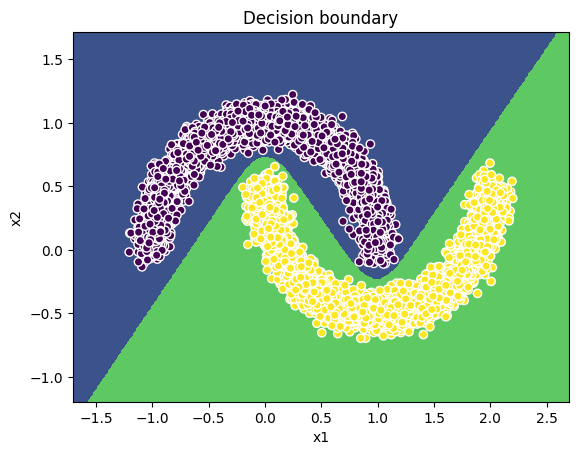

In [49]:
# Visualize the decision boundaries
from dnn_utils import visualize_decision_boundary
visualize_decision_boundary(X, Y, lambda x: predict(x, params_trained))

### Tune your neural network

>__Exercise__: Tune your network from the last exercise by changing the hidden layer's dimension. Use a train/val split of 80/20 of the train set from the last exercise and print out the test accuracy for each hyperparameter choice. Use the function `visualize_decision_boundary()` from the `dnn_utils.py` to visualize how good your network becomes.

In [ ]:
#===========#
# YOUR CODE # ~10 lines
#===========#

### Improve neural network training

>__Extra Exercise__: Play around with the _learning rate_ of the gradient descent. What do you observe? 

In [ ]:
#===========#
# YOUR CODE # 
#===========#

## Further datasets (optional)

The gradient of the weights is also directly obtained from the error via the outer product:>__Extra Exercise__: Try out other datasets listed below and investigate how your dense neural network performs on this data (you will have to train the network anew). 

Datasets:
- `sklearn.datasets.make_blobs()` - keep in mind that your network is only able to handle 2-dimensional features and two classes
- `sklearn.datasets.make_circles()`
- `sklearn.datasets.make_classifications()` 
- `sklearn.datasets.make_hastie_10_2()` 
- `sklearn.datasets.make_gaussian_quantiles()` 
- you can also try out what happens, if you use random data with no structure at all (but two classes) 

In [ ]:
#===========#
# YOUR CODE #
#===========#